In [ ]:
import pandas as pd

df = pd.read_csv(r'C:\Users\MadiL\CS110 CodeBase\cleaned_data.csv')

# Make our crude_prevalence masterpiece
df = df[df['YearStart'] == df['YearEnd']]
df = df[df['StratificationCategory1'] == 'Overall']
df = df[df['DataValueUnit'] == '%']
df = df[df['DataValueType'] == 'Crude Prevalence']
df = df.dropna(subset=['DataValue'])

# Pivot the DataFrame
pivoted_df = df.pivot_table(
    index='LocationDesc',  # States
    columns='Question',    # Unique questions
    values='DataValue',    # The value (e.g., obesity rate, life expectancy, etc.)
    aggfunc='first'       # Since you want one value per state-question pair, 'first' will be sufficient
)

# Reset index to have 'LocationAbbr' as a column instead of an index
pivoted_df.reset_index(inplace=True)

final_df = pivoted_df



C:\Users\MadiL\AppData\Local\Temp\ipykernel_10296\488785431.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\MadiL\CS110 CodeBase\cleaned_data.csv')


### Elbow Method

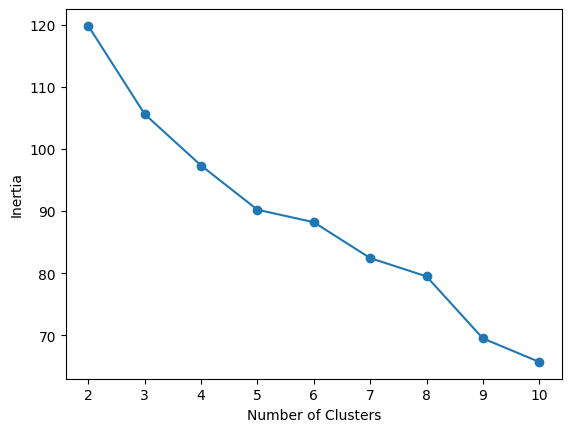

In [5]:
# Elbow method to find optimal clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd

# Extract the DataValues columns (numeric data)
data_values_df = final_df.copy().set_index('LocationDesc').apply(pd.to_numeric, errors='coerce')

# Drop any rows or columns that are NaN after conversion
data_values_df = data_values_df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Step 1: Impute missing values using the mean (or median, depending on your preference)
imputer = SimpleImputer(strategy='mean')  # 'median' or 'most_frequent' can also be options
imputed_data = imputer.fit_transform(data_values_df)

# Step 2: Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Step 3: Apply K-Means clustering
k_values = range(2, 11)  # Number of clusters to try    
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


### K-Means sans PCA

In [7]:
unfinal_df = final_df.copy()

# Step 1: Extract the DataValues columns (numeric data)
# Keep 'LocationAbbr' as a column, not as the index
data_values_df = unfinal_df[['LocationDesc']].join(unfinal_df.drop(columns=['LocationDesc']).apply(pd.to_numeric, errors='coerce'))

# Drop any rows or columns that are NaN after conversion
data_values_df = data_values_df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Step 2: Impute missing values using the mean (or median, depending on your preference)
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(data_values_df.drop(columns=['LocationDesc']))  # Exclude 'LocationDesc' for imputation

# Step 3: Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Step 4: Apply K-Means clustering
optimal_clusters = 3  # Adjust this based on your needs
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_data)

# Step 5: Assign cluster labels to your dataframe
data_values_df['Cluster'] = kmeans.labels_

# Add the 'LocationAbbr' column back for visualization (so it's available for hover_name)
final_df['Cluster'] = data_values_df['Cluster']  # Add cluster labels back to the original final_df
final_df['LocationDesc'] = data_values_df['LocationDesc']  # Add LocationAbbr back

x_feature = 'Diabetes among adults'
y_feature = 'Obesity among adults'

# Now, you can visualize the clusters with Plotly and use 'LocationAbbr' for hover
import plotly.express as px

# Convert 'Cluster' to a categorical type for better coloring
final_df['Cluster'] = final_df['Cluster'].astype('category')

# Plotly scatter plot with categorical coloring
fig = px.scatter(final_df, 
                 x=x_feature, 
                 y=y_feature, 
                 color='Cluster',  # Color by cluster, now categorical
                 hover_name='LocationDesc',  # Show state abbreviation when hovered
                 labels={x_feature: f'{x_feature} CP (%)', 
                         y_feature: f'{y_feature} CP (%)', 
                         'Cluster': 'Cluster'},  # Label adjustments
                 title=f"Clustering of States by {x_feature} and {y_feature} Rates",
                 category_orders={'Cluster': sorted(final_df['Cluster'].unique())})  # Ensures clusters are ordered

# Improve marker appearance
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))

# Adjust layout for a cleaner look
fig.update_layout(
    title_font_size=20,
    xaxis_title=f'{x_feature} CP (%)',
    yaxis_title=f'{y_feature} CP (%)',
    template='plotly_dark',  # You can change this to 'plotly' for a lighter theme
)

fig.show()

# Now, let's print out the list of states in each cluster
for cluster in final_df['Cluster'].cat.categories:
    states_in_cluster = final_df[final_df['Cluster'] == cluster]['LocationDesc'].tolist()
    print(f"Cluster {cluster}: {states_in_cluster}")


Cluster 0: ['Alabama', 'Arkansas', 'Indiana', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 'North Carolina', 'Ohio', 'Oklahoma', 'South Carolina', 'Tennessee', 'West Virginia']
Cluster 1: ['Alaska', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'New York', 'North Dakota', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'United States', 'Utah', 'Vermont', 'Virginia', 'Washington', 'Wisconsin', 'Wyoming']
Cluster 2: ['Arizona', 'Florida', 'Georgia', 'Guam', 'Nevada', 'New Mexico', 'Puerto Rico', 'Texas', 'Virgin Islands']
